In [ ]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 2.9 MB/s 
     |████████████████████████████████| 3.5 MB 2.4 MB/s 


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import numpy as np
from termcolor import colored
from torch._C import dtype
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Explainability_name = 'Guided BP'
Task_name = 'Node Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
#print(np.shape(dataset))
print(data)
print(colored('===========================================================================================================', 'red'))


# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [ ]:
print(len(data.x[0]))
print(len(data.x))
print(len(data.y))
print(data.y[0])
print(f'MAX: {max(data.y)}')
print(f'MIN: {min(data.y)}')
print(data.x[0])
print(len(data.edge_index[0]))


1433
2708
2708
tensor(3)
MAX: 6
MIN: 0
tensor([0., 0., 0.,  ..., 0., 0., 0.])
10556


# **MLP MODEL**

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model_MLP = MLP(hidden_channels=16)
print(model_MLP)


MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [ ]:
model_MLP = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model_MLP.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model_MLP(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model_MLP.eval()
      out = model_MLP(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


# **GCN MODEL**

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

guided_model_GCN = GCN(hidden_channels=16)
print(guided_model_GCN)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


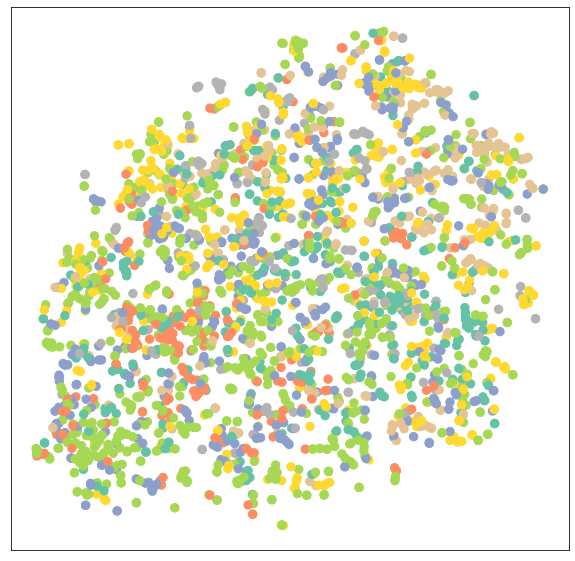

In [ ]:
guided_model_GCN = GCN(hidden_channels=16)
guided_model_GCN.eval()

out = guided_model_GCN(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
guided_optimizer = torch.optim.Adam(guided_model_GCN.parameters(), lr=0.01, weight_decay=5e-4)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [ ]:
def loading_model(load_index):
  model_GCN = GCN(hidden_channels=16)
  optimizer = torch.optim.Adam(params = model_GCN.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  model_GCN.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return model_GCN, optimizer, epoch

In [ ]:
def visualize_losses(g_losses, epoch_history):
  g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Guided Model Loss in Epoch: " + str(epoch_history))

  ax.plot(g_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [ ]:
def train_step():
  guided_model_GCN.train(True)

  guided_optimizer.zero_grad()  
  out_GCN = guided_model_GCN(data.x, data.edge_index)  

  guided_loss = loss_calculations(out_GCN[data.train_mask], data.y[data.train_mask])  
  guided_loss.backward(retain_graph=True)

  guided_optimizer.step()    


  return guided_loss


In [ ]:
LOSS_Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [ ]:
def train(EPOCHS, load_index):
  guided_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    guided_model_training_loss = train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {guided_model_training_loss:.4f}')

    guided_training_loss_per_epoch.append(guided_model_training_loss)

    #break

    if (epoch + load_index + 1) % LOSS_Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(guided_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': guided_model_GCN.state_dict(), 'optimizer_state_dict': guided_optimizer.state_dict(), 'loss': guided_training_loss_per_epoch,}, "/content/drive/My Drive/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")  
  #return model_loss





# **Test Configuration for the Model**

In [ ]:
def guided_test():
  guided_model_GCN.eval()
  g_out = guided_model_GCN(data.x, data.edge_index)
  g_pred = g_out.argmax(dim=1)  
  g_test_correct = g_pred[data.test_mask] == data.y[data.test_mask] 
  g_test_acc = int(g_test_correct.sum()) / int(data.test_mask.sum()) 
  return g_test_acc

Epoch: 001, Guided Model Loss: 1.9463
Epoch: 002, Guided Model Loss: 1.9409
Epoch: 003, Guided Model Loss: 1.9343
Epoch: 004, Guided Model Loss: 1.9275
Epoch: 005, Guided Model Loss: 1.9181
Epoch: 006, Guided Model Loss: 1.9086
Epoch: 007, Guided Model Loss: 1.9015
Epoch: 008, Guided Model Loss: 1.8933
Epoch: 009, Guided Model Loss: 1.8808
Epoch: 010, Guided Model Loss: 1.8685
Epoch: 011, Guided Model Loss: 1.8598
Epoch: 012, Guided Model Loss: 1.8482
Epoch: 013, Guided Model Loss: 1.8290
Epoch: 014, Guided Model Loss: 1.8233
Epoch: 015, Guided Model Loss: 1.8057
Epoch: 016, Guided Model Loss: 1.7966
Epoch: 017, Guided Model Loss: 1.7825
Epoch: 018, Guided Model Loss: 1.7617
Epoch: 019, Guided Model Loss: 1.7491
Epoch: 020, Guided Model Loss: 1.7310
Epoch: 021, Guided Model Loss: 1.7147
Epoch: 022, Guided Model Loss: 1.7056
Epoch: 023, Guided Model Loss: 1.6954
Epoch: 024, Guided Model Loss: 1.6697
Epoch: 025, Guided Model Loss: 1.6538
Epoch: 026, Guided Model Loss: 1.6312
Epoch: 027, 

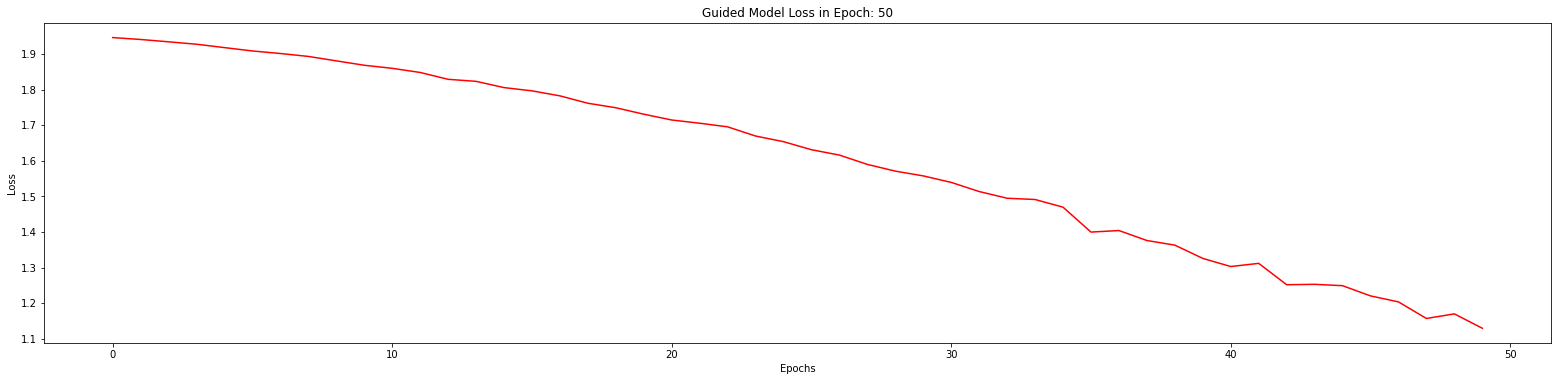

Epoch: 051, Guided Model Loss: 1.0860
Epoch: 052, Guided Model Loss: 1.1080
Epoch: 053, Guided Model Loss: 1.0564
Epoch: 054, Guided Model Loss: 1.0157
Epoch: 055, Guided Model Loss: 1.0362
Epoch: 056, Guided Model Loss: 1.0328
Epoch: 057, Guided Model Loss: 1.0058
Epoch: 058, Guided Model Loss: 0.9865
Epoch: 059, Guided Model Loss: 0.9667
Epoch: 060, Guided Model Loss: 0.9741
Epoch: 061, Guided Model Loss: 0.9769
Epoch: 062, Guided Model Loss: 0.9122
Epoch: 063, Guided Model Loss: 0.8993
Epoch: 064, Guided Model Loss: 0.8769
Epoch: 065, Guided Model Loss: 0.8575
Epoch: 066, Guided Model Loss: 0.8897
Epoch: 067, Guided Model Loss: 0.8312
Epoch: 068, Guided Model Loss: 0.8262
Epoch: 069, Guided Model Loss: 0.8511
Epoch: 070, Guided Model Loss: 0.7711
Epoch: 071, Guided Model Loss: 0.8012
Epoch: 072, Guided Model Loss: 0.7529
Epoch: 073, Guided Model Loss: 0.7525
Epoch: 074, Guided Model Loss: 0.7689
Epoch: 075, Guided Model Loss: 0.7553
Epoch: 076, Guided Model Loss: 0.7032
Epoch: 077, 

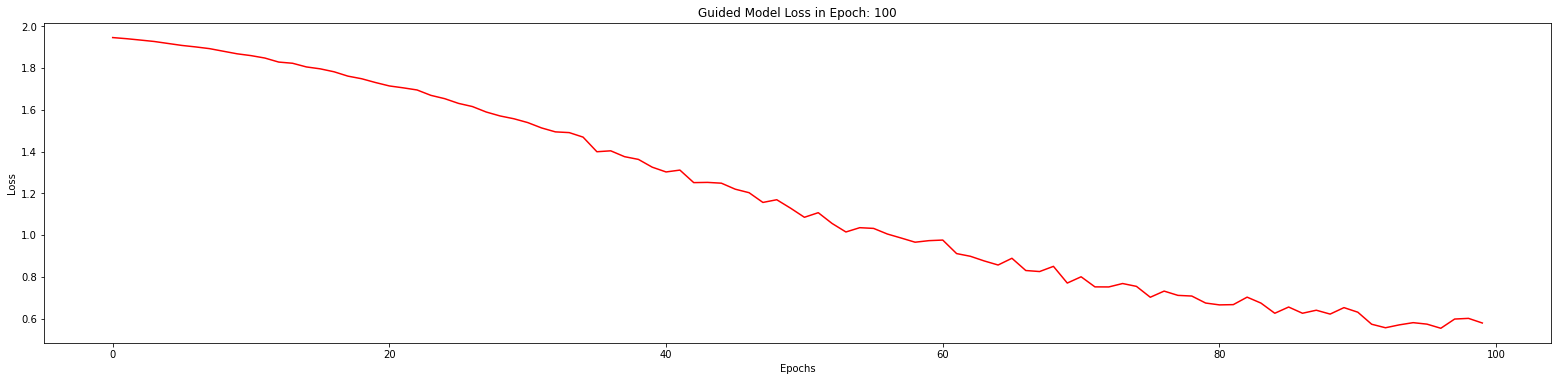

Epoch: 101, Guided Model Loss: 0.5868
Epoch: 102, Guided Model Loss: 0.5272
Epoch: 103, Guided Model Loss: 0.5504
Epoch: 104, Guided Model Loss: 0.5215
Epoch: 105, Guided Model Loss: 0.5505
Epoch: 106, Guided Model Loss: 0.5023
Epoch: 107, Guided Model Loss: 0.5508
Epoch: 108, Guided Model Loss: 0.5422
Epoch: 109, Guided Model Loss: 0.5115
Epoch: 110, Guided Model Loss: 0.5377
Epoch: 111, Guided Model Loss: 0.5178
Epoch: 112, Guided Model Loss: 0.4909
Epoch: 113, Guided Model Loss: 0.4980
Epoch: 114, Guided Model Loss: 0.4880
Epoch: 115, Guided Model Loss: 0.4749
Epoch: 116, Guided Model Loss: 0.4944
Epoch: 117, Guided Model Loss: 0.4825
Epoch: 118, Guided Model Loss: 0.4811
Epoch: 119, Guided Model Loss: 0.4842
Epoch: 120, Guided Model Loss: 0.4883
Epoch: 121, Guided Model Loss: 0.4726
Epoch: 122, Guided Model Loss: 0.4749
Epoch: 123, Guided Model Loss: 0.4745
Epoch: 124, Guided Model Loss: 0.4474
Epoch: 125, Guided Model Loss: 0.4524
Epoch: 126, Guided Model Loss: 0.4918
Epoch: 127, 

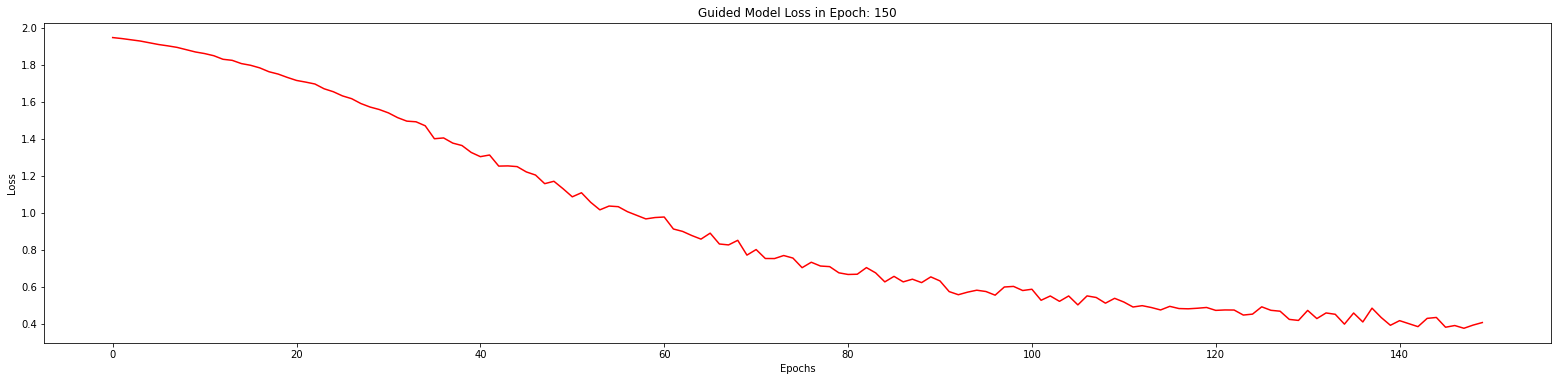

Epoch: 151, Guided Model Loss: 0.4303
Epoch: 152, Guided Model Loss: 0.3937
Epoch: 153, Guided Model Loss: 0.4007
Epoch: 154, Guided Model Loss: 0.4078
Epoch: 155, Guided Model Loss: 0.3977
Epoch: 156, Guided Model Loss: 0.3697
Epoch: 157, Guided Model Loss: 0.3999
Epoch: 158, Guided Model Loss: 0.3596
Epoch: 159, Guided Model Loss: 0.3945
Epoch: 160, Guided Model Loss: 0.3510
Epoch: 161, Guided Model Loss: 0.3494
Epoch: 162, Guided Model Loss: 0.4156
Epoch: 163, Guided Model Loss: 0.3884
Epoch: 164, Guided Model Loss: 0.3471
Epoch: 165, Guided Model Loss: 0.3728
Epoch: 166, Guided Model Loss: 0.3925
Epoch: 167, Guided Model Loss: 0.3856
Epoch: 168, Guided Model Loss: 0.3606
Epoch: 169, Guided Model Loss: 0.3817
Epoch: 170, Guided Model Loss: 0.3357
Epoch: 171, Guided Model Loss: 0.3628
Epoch: 172, Guided Model Loss: 0.3898
Epoch: 173, Guided Model Loss: 0.3746
Epoch: 174, Guided Model Loss: 0.3433
Epoch: 175, Guided Model Loss: 0.3448
Epoch: 176, Guided Model Loss: 0.3631
Epoch: 177, 

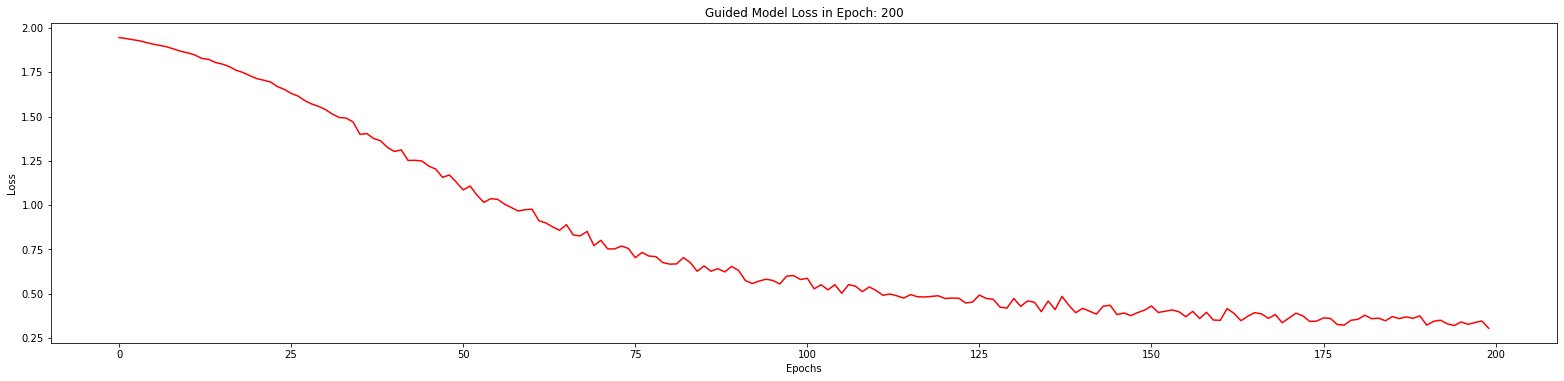

In [ ]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

In [ ]:
guided_test_acc = guided_test()
print(f'Test Accuracy: {guided_test_acc:.4f}')

Test Accuracy: 0.8020


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


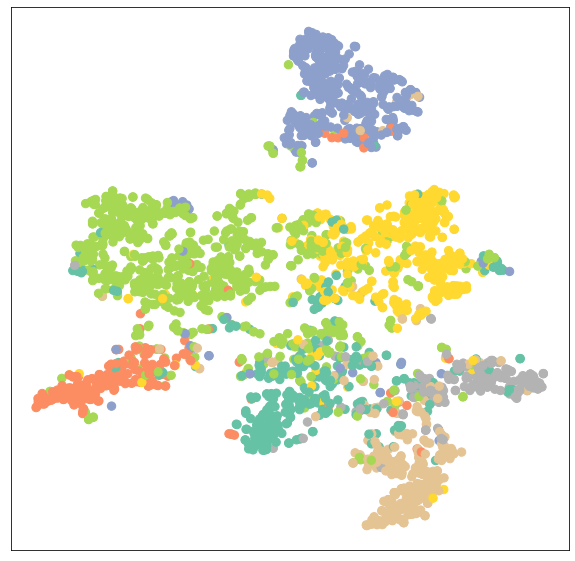

In [ ]:
guided_model_GCN.eval()

guided_test_out = guided_model_GCN(data.x, data.edge_index)
visualize(guided_test_out, color=data.y)

# **Gradients of GuidedBP**


In [ ]:
def accumulate_gradients(model_for_you):
  before_guidance = []
  after_guidance = []
  
  for name, param in model_for_you.named_parameters():
    if name == "conv1.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv2.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
  

  return before_guidance, after_guidance

In [ ]:
holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(guided_model_GCN)

# **GUIDED**
# **Based on the Training Phase, for each of the Hidden Nodes in the First and Second Layers, which Gradient is more important?**

In [ ]:
def guided_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, epoch): 
  layer = 1
  for i in range(len(holder_of_new_gradients[layer])):

    fig1 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer][i], color='r')
    ax2.plot(holder_of_old_gradients[layer][i], color='r')

    plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  layer = 2
  for i in range(len(holder_of_new_gradients[layer+1])):
    fig2 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+1][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+1][i], color='r')

    plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
    


In [ ]:
guided_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

# **WEIGHT vectors and BIASSES**

In [ ]:
print(guided_model_GCN.conv1)
sd = guided_model_GCN.state_dict()
print(len(sd.items()))
whole_weights = sd.items()
#print(whole_weights)
print(colored('===========================================================================================================', 'red'))


#list(model_GCN.state_dict().items())[0][1].data[:]
#print(sd.get('conv1.bias'))
conv1_weights = sd.get('conv1.lin.weight')
conv1_biases = sd.get('conv1.bias')
conv2_weights = sd.get('conv2.lin.weight')
conv2_biases = sd.get('conv2.bias')
print(f'Length of CONV1_Weights: {len(conv1_weights)}')
print(f'Length of CONV1.Bias: {len(conv1_biases)}')
print(f'Length of CONV2_Weights: {len(conv2_weights)}')
print(f'Length of CONV2.Bias: {len(conv2_biases)}')
#print(f'CONV1_Weights: {conv1_weights}')
#print(f'CONV1.Bias: {conv1_biases}')
#print(f'CONV2_Weights: {conv2_weights}')
#print(f'CONV2.Bias: {conv2_biases}')

GCNConv(1433, 16)
4
Length of CONV1_Weights: 16
Length of CONV1.Bias: 16
Length of CONV2_Weights: 7
Length of CONV2.Bias: 7


In [ ]:
####.                   The Mistake which I had made!

'''
def train_step():
  guided_model_GCN.train(True)
  guided_optimizer.zero_grad()  
  out_GCN = guided_model_GCN(data.x, data.edge_index)  
  guided_loss = loss_calculations(out_GCN[data.train_mask], data.y[data.train_mask])  
  guided_loss.backward(retain_graph=True)  


  before_guidance = []
  after_guidance = []

  for name, param in guided_model_GCN.named_parameters():
    if name == "conv1.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv2.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
  
  non_guided_backpropagation_SAME_MODEL(before_guidance)  
  guided_backpropagation_SAME_MODEL(after_guidance)


  guided_optimizer.step() 
'''
